In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import glob
import re
import platform
import importlib
import netCDF4
import multiprocessing as mp
import itertools
import scipy.stats as stats
import seaborn as sns
import rasterio
from rasterio.plot import show

user_name = input("Your home folder's user name?")

if platform.system() == 'Darwin':  # macOS
    base_FP = f'/Users/{user_name}/data'
    cpuserver_data_FP = f'/Users/{user_name}/cpuserver_data'
elif platform.system() == 'Linux':
    base_FP = f'/home/{user_name}/data'
    cpuserver_data_FP = f'/home/{user_name}/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
print(base_FP, cpuserver_data_FP)
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import develop_HydroAI.HydroAI.HLS as hHLS
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Grid as hGrid
importlib.reload(hHLS);
importlib.reload(hPlot);
importlib.reload(hData);
importlib.reload(hGrid);

Your home folder's user name? subin


/home/subin/data /home/subin/cpuserver_data


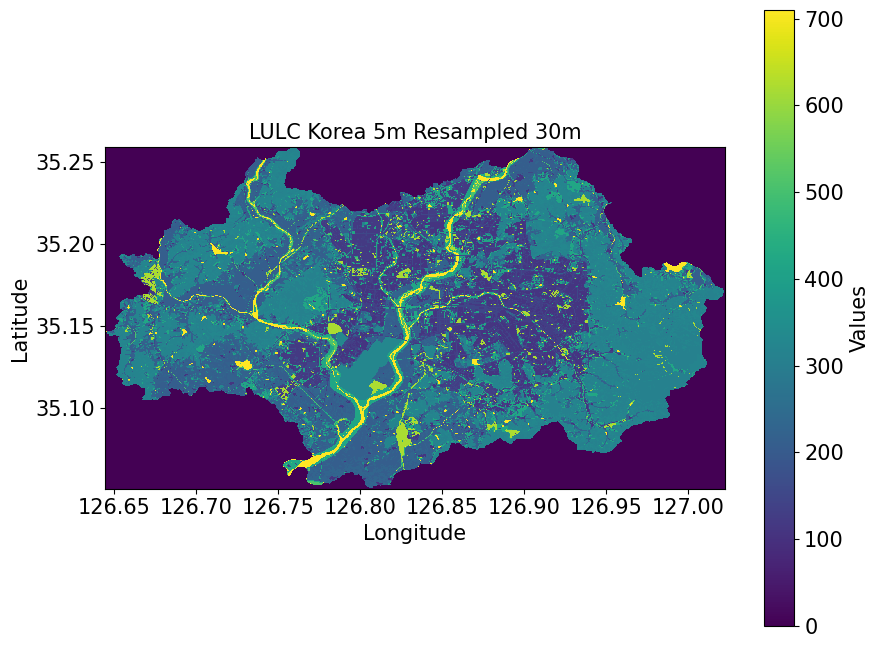

In [12]:
# Open the GeoTIFF file
#file_path = f'{cpuserver_data_FP}/LULC/ROK/South_Korea/LULC_Korea_5m_resampled_30m.tif'
file_path = f'{cpuserver_data_FP}/LULC/ROK/Gwangju/Gwangju_30m.tif'

with rasterio.open(file_path) as src:
    # Read the data from the first band (assuming single band data)
    data = src.read(1)
    
    # Get the coordinates for the pixels
    transform = src.transform
    width = src.width
    height = src.height

    # Get the bounds (left, bottom, right, top)
    bounds = src.bounds
    
    # Generate latitude and longitude for each pixel
    lon = np.linspace(bounds.left, bounds.right, width)
    lat = np.linspace(bounds.top, bounds.bottom, height)
    
    # Create meshgrid for plotting
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(lon_grid, lat_grid, data, cmap='viridis')
    plt.colorbar(label="Values")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("LULC Korea 5m Resampled 30m")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

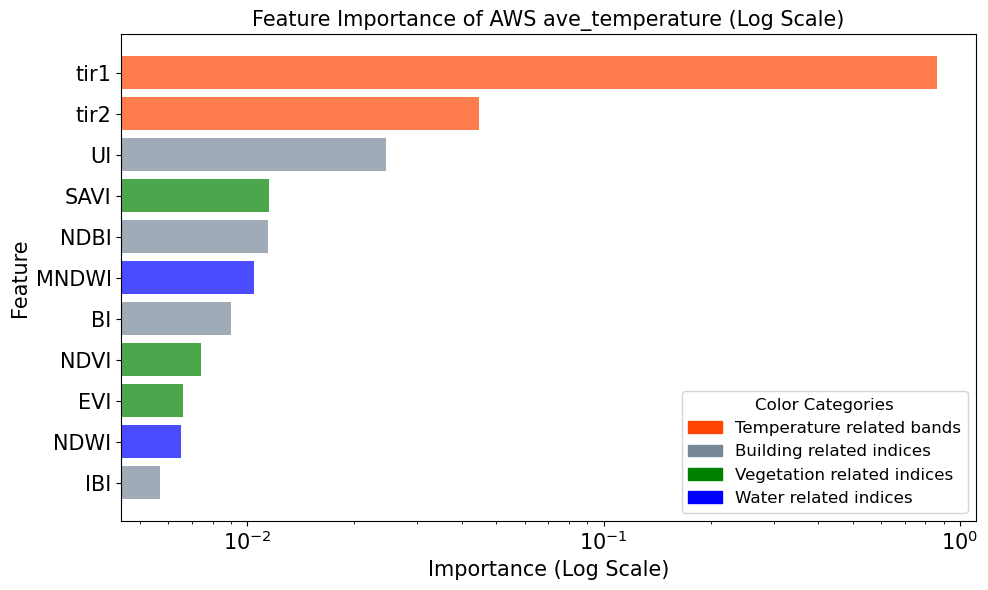

In [184]:
import matplotlib.patches as mpatches

# Load the CSV file
file_path = f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/2013_2024_max/feature_importance.csv' 
df = pd.read_csv(file_path)

# Sort the dataframe by importance for better visualization
df_sorted = df.sort_values(by='importance', ascending=False)

# Define color groups based on the feature categories
color_mapping = {
    'tir1': 'orangered', 'tir2': 'orangered',  # Temperature
    'UI': 'lightslategray', 'NDBI': 'lightslategray', 'BI': 'lightslategray', 'IBI': 'lightslategray',  # Building Index
    'NDVI': 'green', 'EVI': 'green', 'SAVI': 'green',  # Vegetation Index
    'NDWI': 'blue', 'MNDWI': 'blue'  # Water Index
}

# Create a list of colors for each feature based on the color_mapping
colors = df_sorted['feature'].map(color_mapping)

# Plotting the feature importance with log scale
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['feature'], df_sorted['importance'], color=colors, alpha=0.7)  # Use the custom colors
plt.xscale('log')  # Set the x-axis to log scale
plt.xlabel('Importance (Log Scale)')
plt.ylabel('Feature')
plt.title('Feature Importance of AWS ave_temperature (Log Scale)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top

# Add legend for the color categories
legend_elements = [
    mpatches.Patch(color='orangered', label='Temperature related bands'),
    mpatches.Patch(color='lightslategray', label='Building related indices'),
    mpatches.Patch(color='green', label='Vegetation related indices'),
    mpatches.Patch(color='blue', label='Water related indices')
]

plt.legend(handles=legend_elements, loc='lower right', title='Color Categories', fontsize='large', title_fontsize='large')

plt.tight_layout()
plt.savefig(f'Figures/feature_imp_bars.png', dpi=300, bbox_inches='tight', transparent=True)

# Show the plot
plt.show()

/tmp/ipykernel_2265419/387934458.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


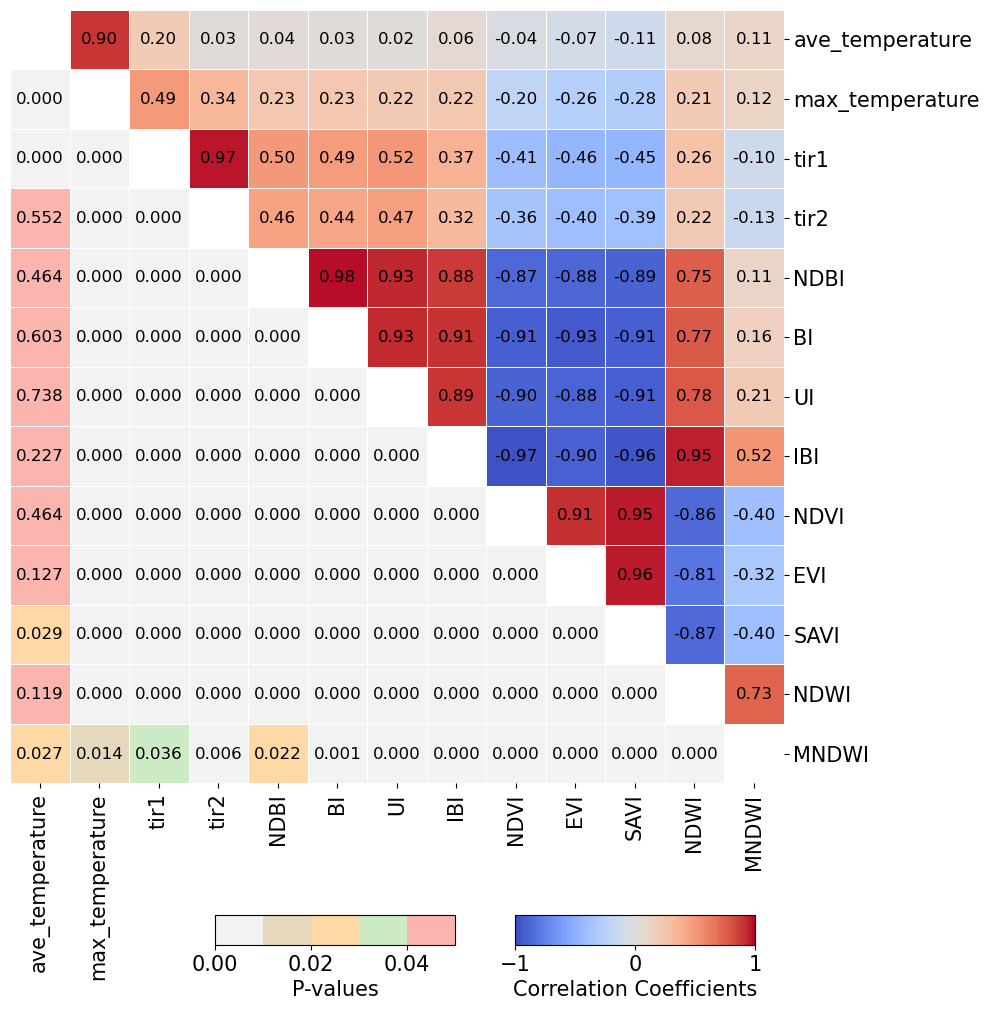

In [207]:
# Sample data for illustration purposes
file_path = f'{cpuserver_data_FP}/HLS/Korea/UHI_project_L30/2013_2024/df_geo_indices.csv' 
df_all_season = pd.read_csv(file_path)

# Extracting only the summer season (June, July, August)
df_all_season['dates'] = pd.to_datetime(df_all_season['dates'], format='%Y%m%d')
df = df_all_season[df_all_season['dates'].dt.month.isin([6, 7, 8])]

df = df.drop(columns=['Unnamed: 0', 'latitude', 'longitude', 'dates'])
df.insert(0, 'tir2', df.pop('tir2'))
df.insert(0, 'tir1', df.pop('tir1'))
df.insert(0, 'max_temperature', df.pop('max_temperature'))
df.insert(0, 'ave_temperature', df.pop('ave_temperature'))

# Calculate the Spearman correlation matrix
corr_matrix = df.corr() #method='spearman')

# Function to compute the p-values
def calculate_pvalues(df):
    pvalues = pd.DataFrame(np.ones((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for col in df.columns:
        for row in df.columns:
            if col != row:
                corr_test = stats.pearsonr(df[col], df[row])
                pvalues.at[row, col] = corr_test[1]
    return pvalues

# Get p-values
pvalues = calculate_pvalues(df)

# Set up the figure with more space for colorbars
fig, ax = plt.subplots(figsize=(12, 10))

# Define two colormaps
correlation_cmap = plt.get_cmap('coolwarm').copy()
pvalue_cmap = plt.get_cmap('Pastel1_r', 5).copy()

# Create a mask for the diagonal (to be white)
mask_diagonal = np.eye(len(corr_matrix), dtype=bool)

# Plot correlation coefficients in the upper triangle
sns.heatmap(corr_matrix, mask=~np.triu(np.ones_like(corr_matrix, dtype=bool)) | mask_diagonal, 
            cmap=correlation_cmap, annot=False, vmin=-1, vmax=1, 
            linewidths=0.5, ax=ax, cbar=False, square=True)

# Overlay p-values in the lower triangle using the second colormap
sns.heatmap(pvalues, mask=np.triu(np.ones_like(pvalues, dtype=bool), 1) | mask_diagonal, 
            cmap=pvalue_cmap, annot=False, vmin=0, vmax=0.05, 
            ax=ax, cbar=False, linewidths=0.5, square=True)

# Add diagonal line or text annotation for p-values in the lower triangle
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        if i < j:  # Upper triangle: correlation coefficients
            plt.text(j + 0.5, i + 0.5, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black', fontsize=12)
        elif i > j:  # Lower triangle: p-values
            plt.text(j + 0.5, i + 0.5, f"{pvalues.iloc[i, j]:.3f}", ha='center', va='center', color='black', fontsize=12)

# Move the y-axis labels to the right side and rotate them horizontally
ax.yaxis.tick_right()
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='left')

# Adjust colorbars position
# Create a new axes for the p-value colorbar on the left
cbar_ax_pval = fig.add_axes([0.3, 0.05, 0.2, 0.03])  # Adjusted width and position for shorter colorbar
# Create a new axes for the correlation colorbar on the right
cbar_ax_corr = fig.add_axes([0.55, 0.05, 0.2, 0.03])  # Adjusted width and position for shorter colorbar

# First colorbar for the p-values on the left
cbar_pval = fig.colorbar(plt.cm.ScalarMappable(cmap=pvalue_cmap, norm=plt.Normalize(vmin=0, vmax=0.05)), 
                         cax=cbar_ax_pval, orientation='horizontal')
cbar_pval.set_label("P-values", fontsize=15)

# Second colorbar for the correlation coefficients on the right
cbar_corr = fig.colorbar(plt.cm.ScalarMappable(cmap=correlation_cmap, norm=plt.Normalize(vmin=-1, vmax=1)), 
                         cax=cbar_ax_corr, orientation='horizontal')
cbar_corr.set_label("Correlation Coefficients", fontsize=15)


# Adjust layout
plt.tight_layout()
plt.savefig(f'Figures/corr_matrix_summer.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

/home/subin/miniconda3/envs/cuml_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/subin/miniconda3/envs/cuml_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/subin/miniconda3/envs/cuml_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/home/subin/miniconda3/envs/cuml_env/lib/python3.10/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setti

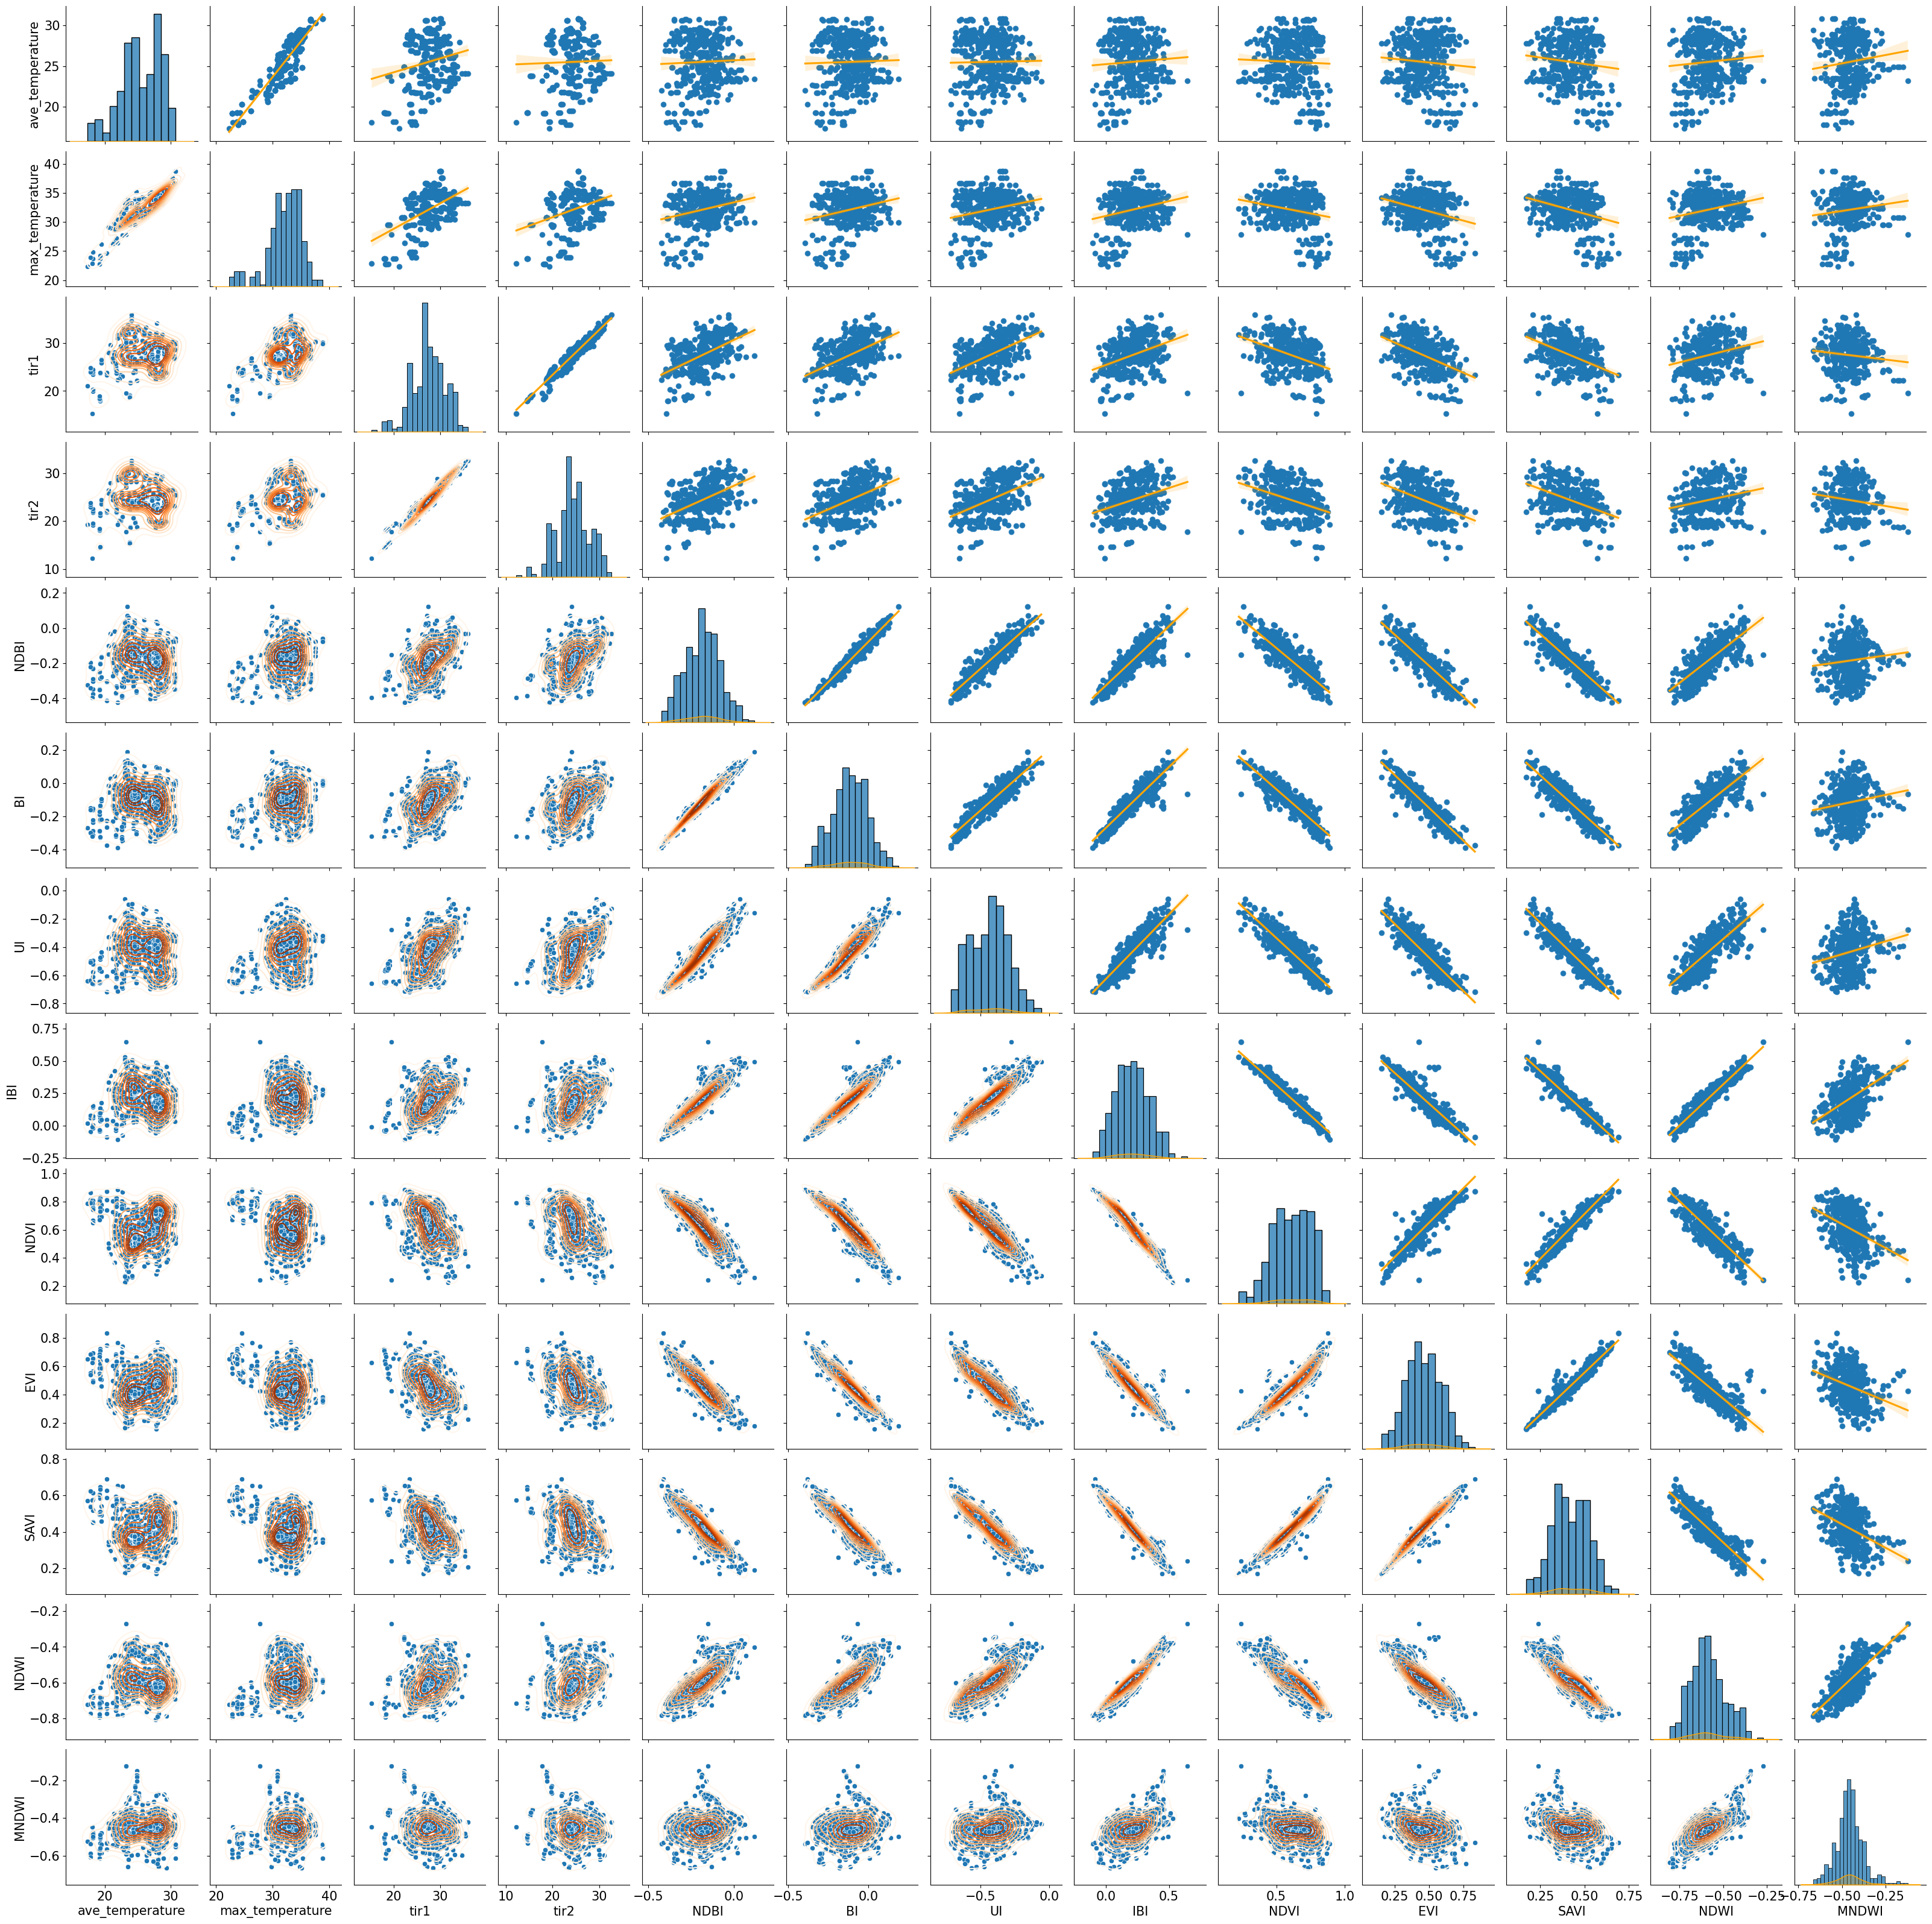

In [219]:
pair_plot = sns.pairplot(df)
pair_plot = pair_plot.map_upper(sns.regplot, 
                                scatter_kws={'color': 'tab:blue'},  # Scatter points in blue
                                line_kws={'color': 'orange'})   # Regression line in orange
pair_plot = pair_plot.map_lower(sns.kdeplot, cmap='Oranges')
pair_plot = pair_plot.map_diag(sns.kdeplot, color='orange', shade=True)

pair_plot.savefig(f'Figures/pair_plot.pdf', bbox_inches='tight', transparent=True)